# Import Library Pandas Dataframe dan Matpolib

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Read data tabel user dan data tabel song

In [2]:
data_pengguna = pd.read_table('10000.txt',header=None)
data_pengguna.columns = ['user_id', 'song_id', 'listen_count']

In [3]:
data_lagu = pd.read_csv('song_data.csv' , sep=",")

# Merge Data User dan Data lagu
## gabungkan kolom judul lagu dengan kolom nama artisnya
## drop nama kolom  yang tidak terpakai di tabel lagu yaitu kolom title, release,artist_name,year

In [4]:
datamerge = pd.merge(data_pengguna, data_lagu.drop_duplicates(['song_id']), on="song_id", how="left")


In [5]:
datamerge['song'] = datamerge['title'].map(str) + " - " + datamerge['artist_name']

In [6]:
datamerge = datamerge.drop(columns=['title', 'release','artist_name','year'])

# Menghitung total jumlah lagu yang diputar pada sebuah lagu, dan menghitung seberapa banyak jumlah user unik pada setiap lagu
## merubah nama kolom user_id menjadi totalUniqueUsers
## merubah nama kolom listen_count menjadi totalArtistPlays
## meanambahkan sebuah kolom yang bernama avgUserPlays
## melakukan normalisasi rating dengan cara menambah sebuah kolom baru bernama rating

In [7]:
data_normalisasi = datamerge.groupby(['song']) \
  .agg({'user_id' : 'count', 'listen_count' : 'sum'}) \
  .rename(columns={"user_id" : 'totalUniqueUsers', "listen_count" : "totalArtistPlays"}) \
  .sort_values(['totalArtistPlays'], ascending = False)

data_normalisasi['avgUserPlays'] = data_normalisasi['totalArtistPlays'] / data_normalisasi['totalUniqueUsers']
data_normalisasi['Rating'] = (data_normalisasi['totalArtistPlays'] - data_normalisasi['totalArtistPlays'].mean())  / data_normalisasi['totalArtistPlays'].std()

## Menggabungkan data sebelumnya dengan kolom baru yang sudah dibuat

In [8]:
datamerge = datamerge.join(data_normalisasi, on="song", how="inner") \
  .sort_values(['listen_count'], ascending=False) \

In [9]:
conditions = [
    (datamerge['Rating'] <= 1),
    (datamerge['Rating'] > 1) & (datamerge['Rating'] <= 10),
    (datamerge['Rating'] > 10) & (datamerge['Rating'] <= 20),
    (datamerge['Rating'] > 20)  & (datamerge['Rating'] <= 30),
    (datamerge['Rating'] > 30)  & (datamerge['Rating'] <= 40)
    ]

In [10]:
values = [1,2,3,4,5]

In [11]:
datamerge['Rating'] = np.select(conditions, values)

In [12]:
rts_gp = datamerge.groupby(by=['Rating']).agg({'user_id': 'count'}).reset_index()
rts_gp.columns = ['Rating', 'Count']


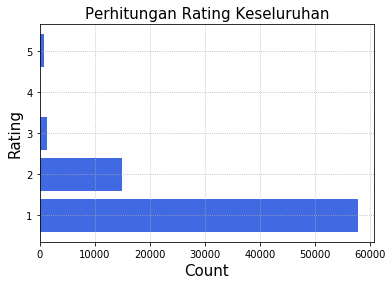

In [13]:
plt.barh(rts_gp.Rating, rts_gp.Count, color='royalblue')
plt.title('Perhitungan Rating Keseluruhan', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()


In [14]:
print('No. of Unique Users    :', datamerge.user_id.nunique())
print('No. of Unique Song :', datamerge.song.nunique())

No. of Unique Users    : 2934
No. of Unique Song : 9749


In [15]:
(datamerge['Rating'] == 5
).sum()

759

# Import Library Surprsise yang diperlukan yaitu model algoritma, cross validation, gridsearch, train test split, dan perhitungan akurasi akhir algoritma


In [16]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import SVDpp
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import NMF
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV


# Melakukan parsing pada data yang mengandung nilai rating di dalamnya

In [17]:
df = pd.DataFrame(datamerge)
reader = Reader(rating_scale=(1,5))

## Melakukan konversi pandas dataframe agar terbaca oleh library surprise

In [18]:
dataakhir = Dataset.load_from_df(df[['user_id', 'song_id', 'Rating']], reader)

# membuat model metode Neighborhood KNN 

In [19]:

KNN_item_cosine = KNNBasic(sim_option = {'name' : 'cosine', 'user_based':False })
KNN_item_pearson = KNNBasic(sim_option = {'name' : 'pearson', 'user_based':False })
KNN_user_cosine = KNNBasic(sim_option = {'name' : 'cosine', 'user_based':True})
KNN_user_pearson = KNNBasic(sim_option = {'name' : 'pearson', 'user_based':True})

# membuat model Algoritma Matrix Factorization

In [20]:
Algoritma_SVD = SVD()
Algoritma_PMF = SVD(biased = False)
Algoritma_SVDpp = SVDpp()
Algoritma_NMF = NMF()

# Melakukan testing cross_validation pada algoritma dengan perhitungan RMSE dan MAE

In [18]:
KNN_user_cosine_cv = cross_validate(KNN_user_cosine, dataakhir, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1187  0.1218  0.1184  0.1172  0.1228  0.1198  0.0022  
MAE (testset)     0.0447  0.0464  0.0435  0.0432  0.0433  0.0442  0.0012  
Fit time          0.40    0.33    0.37    0.31    0.30    0.34    0.04    
Test time         0.69    0.59    0.74    0.54    0.54    0.62    0.08    


In [19]:
KNN_user_pearson_cv = cross_validate(KNN_user_pearson, dataakhir, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1189  0.1176  0.1217  0.1173  0.1160  0.1183  0.0020  
MAE (testset)     0.0447  0.0441  0.0461  0.0439  0.0425  0.0443  0.0012  
Fit time          0.34    0.43    0.41    0.47    0.43    0.42    0.04    
Test time         0.62    0.83    0.68    0.79    0.59    0.70    0.10    


In [20]:
KNN_item_cosine_cv = cross_validate(KNN_item_cosine, dataakhir, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1222  0.1200  0.1167  0.1210  0.1191  0.1198  0.0019  
MAE (testset)     0.0427  0.0438  0.0438  0.0470  0.0441  0.0443  0.0014  
Fit time          0.37    0.40    0.32    0.33    0.31    0.35    0.03    
Test time         0.71    0.62    0.53    0.57    0.52    0.59    0.07    


In [21]:
KNN_item_pearson_cv = cross_validate(KNN_item_pearson, dataakhir, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1191  0.1218  0.1160  0.1192  0.1178  0.1188  0.0019  
MAE (testset)     0.0445  0.0458  0.0429  0.0444  0.0436  0.0442  0.0010  
Fit time          0.39    0.37    0.42    0.44    0.36    0.39    0.03    
Test time         0.68    0.74    0.65    0.64    0.63    0.67    0.04    


In [22]:
SVD_cv = cross_validate(Algoritma_SVD, dataakhir, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1412  0.1417  0.1433  0.1428  0.1393  0.1417  0.0014  
MAE (testset)     0.1015  0.1018  0.1025  0.1021  0.0996  0.1015  0.0010  
Fit time          5.38    6.15    6.79    6.13    4.71    5.83    0.72    
Test time         0.31    0.30    0.18    0.14    0.14    0.21    0.08    


In [23]:
PMF_cv = cross_validate(Algoritma_PMF, dataakhir, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3970  0.3949  0.3955  0.3980  0.3987  0.3968  0.0014  
MAE (testset)     0.1632  0.1584  0.1607  0.1622  0.1601  0.1609  0.0017  
Fit time          5.53    6.21    6.00    5.86    5.04    5.73    0.41    
Test time         0.21    0.28    0.11    0.12    0.11    0.17    0.07    


In [24]:
SVDpp_cv = cross_validate(Algoritma_SVDpp, dataakhir, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0973  0.0965  0.0954  0.0985  0.0992  0.0974  0.0014  
MAE (testset)     0.0683  0.0676  0.0670  0.0688  0.0691  0.0682  0.0008  
Fit time          90.94   87.20   88.30   89.50   85.18   88.23   1.97    
Test time         1.89    2.10    2.18    1.04    1.37    1.72    0.44    


In [25]:
NMF_cv = cross_validate(Algoritma_NMF, dataakhir, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0785  0.0788  0.0772  0.0776  0.0762  0.0776  0.0009  
MAE (testset)     0.0322  0.0320  0.0315  0.0307  0.0309  0.0315  0.0006  
Fit time          8.84    9.14    8.54    7.75    6.09    8.07    1.09    
Test time         0.26    0.21    0.09    0.14    0.12    0.17    0.06    


# Split Trainset dan Testset dimana Trainset = 0.75 dan Testset = 0.25

In [21]:
trainset, testset = train_test_split(dataakhir, test_size=.25)

# Melakukan Fitting model dan membuat prediksinya

In [22]:
prediksi_KNN_user_cosine = KNN_user_cosine.fit(trainset).test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [23]:
prediksi_KNN_user_pearson = KNN_user_pearson.fit(trainset).test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [24]:
prediksi_KNN_item_cosine = KNN_item_cosine.fit(trainset).test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [25]:
prediksi_KNN_item_pearson = KNN_item_pearson.fit(trainset).test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [26]:
prediksi_SVD = Algoritma_SVD.fit(trainset).test(testset)

In [27]:
prediksi_PMF = Algoritma_PMF.fit(trainset).test(testset)

In [28]:
prediksi_SVDpp = Algoritma_SVDpp.fit(trainset).test(testset)

In [29]:
prediksi_NMF = Algoritma_NMF.fit(trainset).test(testset)

# Menghitung accuracy prediksi model algoritma yang sudah dibuat sebelumnya dengan perhitungan accuracy RMSE dan MAE

In [30]:
accuracy.rmse(prediksi_KNN_user_cosine)
accuracy.mae(prediksi_KNN_user_cosine)

RMSE: 0.1305
MAE:  0.0507


0.050734514212967555

In [31]:
accuracy.rmse(prediksi_KNN_user_pearson)
accuracy.mae(prediksi_KNN_user_pearson)

RMSE: 0.1305
MAE:  0.0507


0.050734514212967555

In [32]:
accuracy.rmse(prediksi_KNN_item_cosine)
accuracy.mae(prediksi_KNN_item_cosine)

RMSE: 0.1305
MAE:  0.0507


0.050734514212967555

In [33]:
accuracy.rmse(prediksi_KNN_item_pearson)
accuracy.mae(prediksi_KNN_item_pearson)

RMSE: 0.1305
MAE:  0.0507


0.050734514212967555

In [34]:
accuracy.rmse(prediksi_SVD)
accuracy.mae(prediksi_SVD)

RMSE: 0.1480
MAE:  0.1064


0.10635037643746643

In [35]:
accuracy.rmse(prediksi_PMF)
accuracy.mae(prediksi_PMF)

RMSE: 0.4257
MAE:  0.1765


0.17654328103707115

In [36]:
accuracy.rmse(prediksi_SVDpp)
accuracy.mae(prediksi_SVDpp)

RMSE: 0.1016
MAE:  0.0714


0.07135032558659535

In [37]:
accuracy.rmse(prediksi_NMF)
accuracy.mae(prediksi_NMF)

RMSE: 0.0800
MAE:  0.0327


0.032675997302896026

## Melakukan tuning hyperparameter dengan gridsearchCV yang bertujuan untuk menemukan kemungkinan parameter terbaik untuk meningkatkan tingkat keakurasian algoritma

In [45]:
param_grid = {'k': [40, 60,80,100],
              'sim_options': {'name': ['cosine','pearson'],
                              'user_based': [True,False]},
              }


gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(dataakhir)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

print(gs.best_score['mae'])
print(gs.best_params['mae'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing

In [46]:
param_grid_SVD = {'n_factors' : [50,100,150,200],
                  'lr_all' :   [0.007, 0.01, 0.05],
              'biased' : [True, False]
                  
              }


#for algorithm in[SVD,NMF]:
gs = GridSearchCV(SVD, param_grid_SVD, measures=['rmse', 'mae'], cv=5)

gs.fit(dataakhir)

    # best RMSE score
print(gs.best_score['rmse'])

    # combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
    
    # best RMSE score
print(gs.best_score['mae'])

    # combination of parameters that gave the best RMSE score
print(gs.best_params['mae'])

0.05166321333154764
{'n_factors': 50, 'lr_all': 0.05, 'biased': True}
0.03419639981080277
{'n_factors': 50, 'lr_all': 0.05, 'biased': True}


In [47]:
param_grid_SVDpp = {'n_factors' : [20,40,60,80],
                     'lr_all' :   [0.007, 0.01, 0.05],
              
              }


#for algorithm in[SVD,NMF]:
gs = GridSearchCV(SVDpp, param_grid_SVDpp, measures=['rmse', 'mae'], cv=5)

gs.fit(dataakhir)

    # best RMSE score
print(gs.best_score['rmse'])

    # combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
    
    # best RMSE score
print(gs.best_score['mae'])

    # combination of parameters that gave the best RMSE score
print(gs.best_params['mae'])

0.040721030001857304
{'n_factors': 20, 'lr_all': 0.05}
0.025926700737192065
{'n_factors': 20, 'lr_all': 0.05}


In [48]:
param_grid_NMF = {'n_factors' : [20,40,60,80],
                     'biased' : [True, False],
                   'lr_bu' :   [0.007, 0.01, 0.05],
                   'lr_bi'  :   [0.007, 0.01, 0.05]
              
              }


#for algorithm in[SVD,NMF]:
gs = GridSearchCV(NMF, param_grid_NMF, measures=['rmse', 'mae'], cv=5)

gs.fit(dataakhir)

    # best RMSE score
print(gs.best_score['rmse'])

    # combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
    
    # best RMSE score
print(gs.best_score['mae'])

    # combination of parameters that gave the best RMSE score
print(gs.best_params['mae'])

0.07136367603757934
{'n_factors': 80, 'biased': False, 'lr_bu': 0.01, 'lr_bi': 0.007}
0.02835001960682505
{'n_factors': 80, 'biased': False, 'lr_bu': 0.01, 'lr_bi': 0.007}


In [49]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [50]:
print(results_df)

    split0_test_rmse  split1_test_rmse  split2_test_rmse  split3_test_rmse  \
0           1.235090          1.135782          1.186101          1.148887   
1           1.172440          1.520212          1.129992          1.450984   
2           1.279778          0.973607          0.970700          2.220031   
3           0.997431          1.220369          1.483156          1.239139   
4           0.931045          1.088774          1.208363          1.468988   
..               ...               ...               ...               ...   
67          0.071967          0.072947          0.071017          0.072212   
68          0.071578          0.072767          0.070775          0.071185   
69          0.071397          0.072358          0.070981          0.071259   
70          0.072773          0.072941          0.071007          0.072902   
71          0.071113          0.072672          0.071299          0.072286   

    split4_test_rmse  mean_test_rmse  std_test_rmse  rank_test_

In [51]:
## Mengimplementasikan ulang Algoritma dengan parameter terbaik dari hasil pencarian gridsearchcv

In [38]:
KNN_user_cosine_best_parameter = KNNBasic(k=40,sim_option = {'name' : 'cosine', 'user_based':True})


In [39]:
SVD_Best_Parameter = SVD(n_factors = 50, lr_all = 0.05, biased= True)

In [40]:
SVDpp_Best_Parameter = SVDpp(n_factors = 20, lr_all = 0.05)

In [41]:
NMF_Best_Parameter = NMF(n_factors = 80, biased= False)

# Melakukan fitting model dan membuat prediksi

In [42]:
prediksiKNN = KNN_user_cosine_best_parameter.fit(trainset).test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [43]:
prediksiSVD = SVD_Best_Parameter.fit(trainset).test(testset)

In [44]:
prediksiSVDpp = SVDpp_Best_Parameter.fit(trainset).test(testset)

In [45]:
prediksiNMF = NMF_Best_Parameter.fit(trainset).test(testset)

## Menghitung tingkat accuracy algoritma dengan RMSE dan MAE

In [60]:
accuracy.rmse(prediksiKNN)
accuracy.mae(prediksiKNN)

RMSE: 0.1297
MAE:  0.0523


0.05226347143399612

In [61]:
accuracy.rmse(prediksiSVD)
accuracy.mae(prediksiSVD)

RMSE: 0.0549
MAE:  0.0362


0.036186034990110166

In [62]:
accuracy.rmse(prediksiSVDpp)
accuracy.mae(prediksiSVDpp)

RMSE: 0.0445
MAE:  0.0279


0.02786746515384943

In [63]:
accuracy.rmse(prediksiNMF)
accuracy.mae(prediksiNMF)


RMSE: 0.0748
MAE:  0.0297


0.02974734440084554

# MEMBANDINGKAN 2 KINERJA ALGORITMA YANG BERBEDA

In [38]:
from __future__ import (absolute_import, division, print_function,             
                        unicode_literals)                                      
import pickle
import os
from surprise import dump


# Menyimpan Hasil Prediksi algoritma ke dalam dump

In [39]:
dump.dump('./dump_KNN_User_cosine', prediksi_KNN_user_cosine , KNN_user_cosine)
dump.dump('./dump_SVD', prediksi_SVD  ,Algoritma_SVD )

# Menggunakan data dalam dump

## Membuat dataframe pada masing-masing algoritma yang berisi id pengguna, id item, nilai rating asli, nilai rating hasil prediksi, dan penjelasan lebih detail

## Menghitung Error prediksi dengan cara melakukan pengurangan terhadap nilai rating sebenarnya dengan nilai rating hasil prediksi.

In [40]:

prediksi_KNN_user_cosine , KNN_user_cosine = dump.load('./dump_KNN_User_cosine')
prediksi_SVD, Algoritma_SVD  = dump.load('./dump_SVD_best_param')

df_knn = pd.DataFrame(prediksi_KNN_user_cosine, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_svd = pd.DataFrame(prediksi_SVD, columns=['uid', 'iid', 'rui', 'est', 'details'])    

df_knn['err'] = abs(df_knn.est - df_knn.rui)
df_svd['err'] = abs(df_svd.est - df_svd.rui)



# Menghitung signifikan error masing-masing algoritma.

In [41]:
Signifcant_Error = ((df_svd['err'].mean() - df_knn['err'].mean())*(df_svd['err'].mean() - df_knn['err'].mean())) / (df_svd['err'].mean() + df_knn['err'].mean())

In [42]:
print(Signifcant_Error)

0.019467287184529142


In [43]:
df_svd.head()

uid                 iid  rui  \
0  a979f3e134e98e5630bd9b117e1a2825ce4db463  SOMDVSL12A6D4F7230  2.0   
1  fcdba14d175029dc693a87743d1f85c069e863e1  SOREPNQ12A58A7B49E  1.0   
2  9c4e14bbd043846b632d3737f08104dcaeb88142  SOLRPJX12A58A79808  2.0   
3  d838e97500dfcef25dc123ce501e2da0e6c361bb  SOBHIJO12A6D4FA26C  1.0   
4  103a439d41748ecc78ad5510d2a3c9042281ed4f  SOBJKAC12AB017E1DC  1.0   

        est                    details       err  
0  1.605598  {'was_impossible': False}  0.394402  
1  1.000000  {'was_impossible': False}  0.000000  
2  1.782622  {'was_impossible': False}  0.217378  
3  1.009970  {'was_impossible': False}  0.009970  
4  1.000000  {'was_impossible': False}  0.000000

# Menampilkan Prediksi algoritma SVD ketika error yang dihasilkan prediksi > 0,5

In [44]:
df_svd[df_svd.err > 0.5]

uid                 iid  rui  \
241    831a55f674808f31aab537601c87ccdd5bc4b8bf  SOQLNEY12B0B8062FA  2.0   
330    0a004c08b700e4edb74b44c2dbceca4280760a9a  SODYLVD12AB0182BEE  2.0   
390    9b1a2cbd5d5c40fa18ca5c38fc6d5b6dc2921dc4  SOACBLB12AB01871C7  2.0   
488    bc3551591ed12f1900f06d9499a4314a78348107  SOAZFQH12A8C13D101  2.0   
874    8cc3c6c8bc8ddbc22d23ec4e5660365ed24af8f9  SOZQSVB12A8C13C271  3.0   
...                                         ...                 ...  ...   
17586  7f9a49ee5ee63bc2e97d0111b52991254d99b024  SOZQLLE12A6D4F7170  2.0   
17699  6349cbb6f2b60495d0443bd4212f6b0015823668  SOOENZJ12AB0187937  2.0   
17893  0e741cfe121bb619177be8d8a135a2d3692d9c90  SOWEFXC12A6D4FA230  2.0   
18155  7b9bce4c88f478500d4b5766acb1765f86983631  SOGRAGY12A6D4F7248  2.0   
18261  abfef43751e880728b44adef59511e5af49b4055  SOODQWW12A8C135E53  2.0   

            est                    details       err  
241    1.434138  {'was_impossible': False}  0.565862  
330    1.243032  {'was_impossible': False}  0.756968  
390    1.424206  {'was_impossible': False}  0.575794  
488    1.291553  {'was_impossible': False}  0.708447  
874    1.598114  {'was_impossible': False}  1.401886  
...         ...                        ...       ...  
17586  1.454808  {'was_impossible': False}  0.545192  
17699  1.272028  {'was_impossible': False}  0.727972  
17893  1.429636  {'was_impossible': False}  0.570364  
18155  1.496585  {'was_impossible': False}  0.503415  
18261  1.377953  {'was_impossible': False}  0.622047  

[105 rows x 6 columns]

# Menampilkan Prediksi algoritma KNN ketika error yang dihasilkan prediksi > 0,5

In [45]:
df_knn[df_knn.err > 0.5]

uid                 iid  rui  \
524    5b7ff9af1d60484e8e378da50265779e7052a4e6  SOVHUFT12AAA15FD32  2.0   
778    fadf4a94e2b962049b11f0567498a2f85469571c  SOOGNOZ12AAF3B2936  2.0   
888    320dccf45fb1b15fa16258f6ec4383213283ec39  SOBHNKR12AB0186218  2.0   
967    10e1c96eeaf82f3076fe31bed9a67bb733ef9ff5  SOJTDUS12A6D4FBF0E  2.0   
994    fc35945f8895c6ca69ad9cb45b7bc47a3cc86738  SORQMMA12A6D4F6F41  2.0   
...                                         ...                 ...  ...   
18157  787ac5b8c2d7c884f4f0c15e267d519fbf4b0f56  SOVHUFT12AAA15FD32  2.0   
18188  42c9fba813dd9ca8ca3673277a0f923b6845a7a6  SOLICIM12A8C132361  2.0   
18217  3ae4bbc2b3f93e4d789f46a1a0d9c30a33063340  SOJQWUD12AB017DD5E  2.0   
18533  b264f4bea8d4dfa446d644f65f6c55b18adca27e  SOWWWFF12A6701C7EB  2.0   
18539  41c5b7e99173ee92361de263dfc0c5481e902c16  SOMAKIT12A58A7E292  2.0   

            est                                            details       err  
524    1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
778    1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
888    1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
967    1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
994    1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
...         ...                                                ...       ...  
18157  1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
18188  1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
18217  1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
18533  1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
18539  1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  

[129 rows x 6 columns]

# Menampilkan Prediksi KNN ketika Error yang dihasilkan oleh Prediksi SVD >= 0.5

In [46]:
df_knn[df_svd.err >= 0.5]

uid                 iid  rui  \
241    ec52a863cc6e439053009f5112aae481a976330e  SOQNOAF12A8151AB86  1.0   
330    c8128cfbce999bfa566c6684d991092d45a7e5db  SONUWMR12AF72A374B  1.0   
390    1ee591a388274035a4fd8a4ae40a9589d320bb9d  SOHEMBB12A6701E907  2.0   
488    7c86176941718984fed11b7c0674ff04c029b480  SOGPBAW12A6D4F9F22  2.0   
874    89104dd85ad671b5180c2e34b895c7e181d6f852  SOJRNUM12A8AE47F2F  1.0   
...                                         ...                 ...  ...   
17586  806ccae96c8ecb1c198482aff785ccd6bbe17143  SOVWADY12AB0189C63  2.0   
17699  6d4698e5c77b56e54c5e4ced67da7b99fb6dfdf6  SOMZDPI12A58A7ABCC  1.0   
17893  3887c145fb91a26b3ce9c80903231539411c601e  SOIEVLM12A6D4FC37B  1.0   
18155  127f6e2bbb86d878464ed08131b4103a2fcef1e6  SOPROPB12A8C1385BD  1.0   
18261  adbd40c4f3fe78e7f49f491ea04859ea07de1ed1  SOAXGBS12A6310E17A  1.0   

            est                                            details       err  
241    1.000000           {'actual_k': 6, 'was_impossible': False}  0.000000  
330    1.000000           {'actual_k': 6, 'was_impossible': False}  0.000000  
390    2.000000          {'actual_k': 31, 'was_impossible': False}  0.000000  
488    2.000000          {'actual_k': 40, 'was_impossible': False}  0.000000  
874    1.000000           {'actual_k': 5, 'was_impossible': False}  0.000000  
...         ...                                                ...       ...  
17586  2.000000          {'actual_k': 40, 'was_impossible': False}  0.000000  
17699  1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.276135  
17893  1.000000           {'actual_k': 1, 'was_impossible': False}  0.000000  
18155  1.000000           {'actual_k': 4, 'was_impossible': False}  0.000000  
18261  1.000000           {'actual_k': 4, 'was_impossible': False}  0.000000  

[105 rows x 6 columns]

# Menampilkan Prediksi SVD ketika Error yang dihasilkan oleh Prediksi KNN >=0.5

In [47]:
df_svd[df_knn.err >= 0.5]

uid                 iid  rui  \
524    dc1a4572bcb4e54532db50fc7571455ad06ccb04  SOLFXKT12AB017E3E0  2.0   
778    b2bb7d937ca86ff5df2965e6c59e8ba23d8676a7  SOYIIBR12A58A7BADD  1.0   
888    cea5d4345acd83e823e7e02839521455045c29b6  SOJYMBF12A58A7E245  1.0   
967    d35ca782315a69bd2192337eea840d8ab252ffbb  SOPKVQT12A6701FB27  1.0   
994    b61afb42335287239bd40e1dea50d849cbf8a9a9  SONEYTB12AF72A73F0  1.0   
...                                         ...                 ...  ...   
18157  9c8bdd66608468fe0779a978765aa8760572c99f  SOOICCF12A6701FBD3  1.0   
18188  17a9f10f660ef4183522be1c5a64f3d4be62f122  SOPLJDD12AAF3B2C27  1.0   
18217  09a254cdf7b6abff2facc85aeae9536810304317  SOOSADY12A6701F119  1.0   
18533  5942ea16965c68f772667b2b3a87527a9ffa923f  SOGQQST12A6701D95C  1.0   
18539  71c1e74cec63f582da9ff77bf0dcdc06819a9740  SOTFNJM12AB01816B4  1.0   

            est                    details       err  
524    2.001846  {'was_impossible': False}  0.001846  
778    1.119567  {'was_impossible': False}  0.119567  
888    1.076996  {'was_impossible': False}  0.076996  
967    1.021149  {'was_impossible': False}  0.021149  
994    1.108108  {'was_impossible': False}  0.108108  
...         ...                        ...       ...  
18157  1.000000  {'was_impossible': False}  0.000000  
18188  1.140362  {'was_impossible': False}  0.140362  
18217  1.000000  {'was_impossible': False}  0.000000  
18533  1.158318  {'was_impossible': False}  0.158318  
18539  1.007007  {'was_impossible': False}  0.007007  

[129 rows x 6 columns]

# Menampilkan 10 Hasil prediksi terburuk dari KNN 

In [48]:
df_knn.iloc[df_knn.sort_values(by='err')[-10:].index]

uid                 iid  rui  \
1990   5230748f8c48b0fd32ea0e508983fb115b2e70d6  SOAJAFJ12A58A7B75A  2.0   
13940  249e86c60ec6fce5c8588d51fd94e85dd47ecff7  SOSLQQJ12AB017BDCC  2.0   
13992  be68695bf20fc8a1365d138ed6b1e43b535df8cf  SOQBMFK12A8C13835B  2.0   
17056  ea6cbdb88a3bead8ace9c163d8e8eca78e374a19  SOEPZQS12A8C1436C7  2.0   
14071  e75d2f023ea6ad48eab8d168e577b2eb3d6e790f  SOSXZRY12A8C1442F0  2.0   
1824   7097f97f0dc770088df9fd235e8b6b62cd235e2d  SOHYLXU12A8C139492  2.0   
2100   53fc663a07c83b5b1c6ad969c4fab39268c00c3e  SOLZEED12A6D4FA8C9  2.0   
15974  16d80debf70592c40ef9cd4be13fac9c0ed6891b  SOASWDH12A8C1325EE  2.0   
16725  e50058d80752fe47f2567bc2b40743beae9b351d  SOAXGDH12A8C13F8A1  3.0   
3374   ae9ea883c8a67dc27a07267c150100a0e71ddf5f  SOAUWYT12A81C206F1  5.0   

            est                                            details       err  
1990   1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
13940  1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
13992  1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
17056  1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
14071  1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
1824   1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
2100   1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
15974  1.276135  {'was_impossible': True, 'reason': 'Not enough...  0.723865  
16725  1.276135  {'was_impossible': True, 'reason': 'Not enough...  1.723865  
3374   1.276135  {'was_impossible': True, 'reason': 'Not enough...  3.723865

# Menampilkan 10 Hasil prediksi terburuk dari SVD

In [49]:
df_svd.iloc[df_svd.sort_values(by='err')[-10:].index]

uid                 iid  rui  \
7758   f86d07cafe10bf1c1ac73c0c14e58ba01084087b  SOSAGXR12A6D4FB483  2.0   
3075   b1269307f2ae8c17062c6aea2502b099aad517b6  SOFZWTX12A8C138B1D  2.0   
11809  91964f2b264a1068806b48b3d6902a9e0f833fe4  SOPUFLQ12A8C13B1A1  2.0   
2938   f8ae59c070d0b3fadc84c4d9f18475a61d7d37eb  SOSXZRY12A8C1442F0  2.0   
5819   eb671bc38ee5d5d13b815fef98f1e9de44580c45  SOANOQW12A58A793D2  2.0   
13807  0aae3885afd9ec62df38635031d1e00cf7c091db  SOJHQCA128CB806336  2.0   
1516   230a15dcb189ff389bc907c52cf1bba6f6e9cd06  SOANOQW12A58A793D2  2.0   
11669  9fbece735fbba4ea0a3f6618777ed4e8873bf6b7  SOTTOFB12AC4688BA6  2.0   
12607  4773bb29a101c444c4209ba649af278e0f2ff5e3  SOHNJFX12AB017B82A  2.0   
874    8cc3c6c8bc8ddbc22d23ec4e5660365ed24af8f9  SOZQSVB12A8C13C271  3.0   

            est                    details       err  
7758   1.222841  {'was_impossible': False}  0.777159  
3075   1.221121  {'was_impossible': False}  0.778879  
11809  1.209504  {'was_impossible': False}  0.790496  
2938   1.204916  {'was_impossible': False}  0.795084  
5819   1.182174  {'was_impossible': False}  0.817826  
13807  1.168706  {'was_impossible': False}  0.831294  
1516   1.159673  {'was_impossible': False}  0.840327  
11669  1.152995  {'was_impossible': False}  0.847005  
12607  1.044361  {'was_impossible': False}  0.955639  
874    1.598114  {'was_impossible': False}  1.401886

# Melihat seberapa perbedaan prediksi yang dihasilkan dari kedua algoritma

In [60]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook

<IPython.core.display.Javascript object>


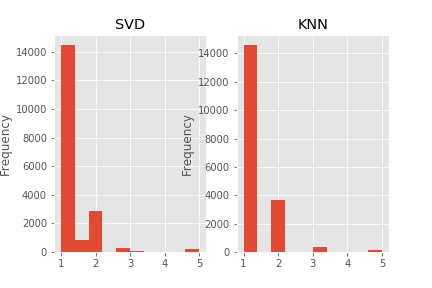

In [61]:
matplotlib.style.use('ggplot')

figure, (ax1, ax2) = plt.subplots(1, 2)

df_svd.est.plot(kind='hist', title='SVD', ax=ax1)
df_knn.est.plot(kind='hist', title='KNN', ax=ax2)